# CS4248 Project - Labelled Unreliable News (LUN)

## Imports

In [17]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import gensim

import warnings
warnings.filterwarnings('ignore')

In [18]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

stop_words = set(stopwords.words('english'))
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stemmer = None
# lemmatizer = None

TEST_SIZE = 0.1
SMOOTHING = 1.0
NGRAM_RANGE = (1, 1)

## Helper Functions

In [19]:
def preprocess(sentence, lower_case=True, remove_punctuation=True, replace_contractions=True):
    if lower_case:
        sentence = sentence.lower()
    if remove_punctuation:
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    if replace_contractions:
        news = sentence.split()
        new_news = []
        for word in news:
            if word in contractions:
                new_news.append(contractions[word])
            else:
                new_news.append(word)
        sentence = " ".join(new_news)
    return sentence

In [20]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def tokenize(sentence, stemmer=stemmer, lemmatizer=lemmatizer, remove_stop_words=False, add_pos_tag=False):
    tokens = word_tokenize(sentence)
    
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_words]
    if add_pos_tag:
        tokens = pos_tag(tokens)
    if stemmer:
        tokens = [stemmer.stem(token) for token in tokens]
    if lemmatizer:
        if add_pos_tag:
            token = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for (token, tag) in tokens]
        else:
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
        
        
    return tokens

In [21]:
# def get_wordnet_pos(treebank_tag):
    
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return ''
    
# def tokenize(sentence):
    
#     tokens = pos_tag(word_tokenize(sentence))
   
#     wnl = WordNetLemmatizer()
    
#     for (token, tag) in tokens:
       
#         if (get_wordnet_pos(tag) == ''):
#            continue
       
#         token = wnl.lemmatize(token, get_wordnet_pos(tag))     
      
#     return tokens

## Load Data

In [22]:
full_train_df = pd.read_csv('raw_data/fulltrain.csv', header=None)
full_train_df.columns = ['label', 'text']
full_train_df.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [23]:
train_df = full_train_df.drop_duplicates(subset=['text'])
print(f"No. training samples (all classes): {len(train_df)}")

No. training samples (all classes): 48652


## Training

In [24]:
X = train_df['text'].values
y = train_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=42)
X_train.shape, X_test.shape

((43786,), (4866,))

In [25]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, smooth_idf=True, preprocessor=preprocess, tokenizer=tokenize, token_pattern=None)
# Uncomment for default TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, smooth_idf=True)

In [26]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Vocabulary size: {len(feature_names)}")
print(feature_names[:150])

KeyError: ''

In [ ]:
print(X_train_tfidf.shape)
print(X_train_tfidf)

(43786, 472937)
  (0, 19808)	0.06530118786560557
  (0, 18027)	0.04941743710506183
  (0, 22366)	0.06530118786560557
  (0, 347935)	0.02577341843676289
  (0, 70310)	0.06289283008015929
  (0, 37624)	0.05706695820993641
  (0, 80545)	0.0261239589641832
  (0, 82769)	0.018242854646372514
  (0, 45690)	0.05517542548046875
  (0, 6882)	0.019422599603045092
  (0, 637)	0.018894079019562762
  (0, 264305)	0.022401015311942152
  (0, 460670)	0.03831519291400432
  (0, 281479)	0.08186509653499467
  (0, 4961)	0.03973615534122727
  (0, 15072)	0.021631495015470716
  (0, 83648)	0.03344257348437004
  (0, 148155)	0.012248511462287209
  (0, 99439)	0.033920325301198165
  (0, 424617)	0.05991182291496528
  (0, 348471)	0.01588928791906389
  (0, 77477)	0.00850799376093892
  (0, 213095)	0.039816969392545996
  (0, 58788)	0.012903695320793959
  (0, 128356)	0.013088360748129692
  :	:
  (43785, 223800)	0.014130911989639512
  (43785, 242567)	0.03880945776719614
  (43785, 417800)	0.010466196040468273
  (43785, 279403)	0.017

## Logistic Regression

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=200).fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_train_tfidf)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 0.9842415383912666
F1 score: 0.9833565308153358


### Testing

In [ ]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = clf.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy: 0.958281956432388
F1 score: 0.9575503780556521


### Validation

In [ ]:
test_df = pd.read_csv('raw_data/balancedtest.csv', header=None, names=['label', 'text'])
print(f"No. test samples (all classes): {len(test_df)}")
test_df.sample(5)

No. test samples (all classes): 3000


,label,text
2765,4,The United States will urge governments around...
2013,3,Many nations formerly of the under-developed ...
1545,3,Schizophrenia is a disabling brain disorder c...
1801,3,-cancer_foods_broccoli.html Tweet (NewsTarget)...
2173,3,Cancer. Heart disease. High blood pressure. O...


In [ ]:
X_val = test_df['text'].values
y_val = test_df['label'].values
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_val_tfidf.shape

(3000, 472937)

In [ ]:
y_pred_val = clf.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.731
F1 score: 0.714381672218099


In [ ]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.87      0.82      0.84       750
        hoax       0.85      0.33      0.48       750
  propaganda       0.56      0.87      0.68       750
    reliable       0.81      0.89      0.85       750

    accuracy                           0.73      3000
   macro avg       0.77      0.73      0.71      3000
weighted avg       0.77      0.73      0.71      3000



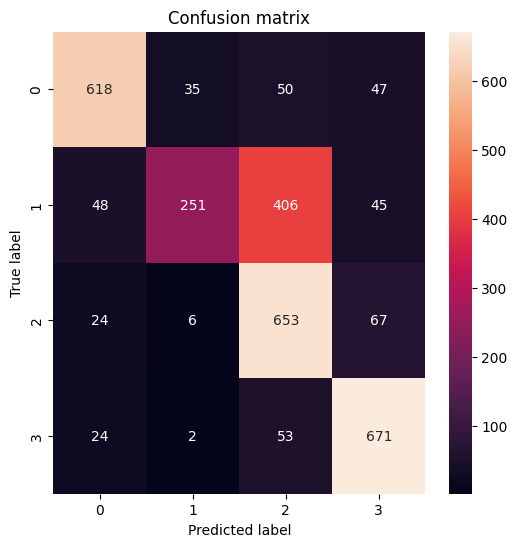

In [ ]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	

## Naive Bayes

In [ ]:
nb = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_train_tfidf)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 0.6179829169140821
F1 score: 0.4898057969352427


### Testing

In [ ]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = nb.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy: 0.5836415947390053
F1 score: 0.44198248855428257


### Validation

In [ ]:
y_pred_val = nb.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.32766666666666666
F1 score: 0.2356750682280634


In [ ]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.66      0.20      0.31       750
        hoax       1.00      0.00      0.00       750
  propaganda       0.28      1.00      0.44       750
    reliable       1.00      0.11      0.20       750

    accuracy                           0.33      3000
   macro avg       0.73      0.33      0.24      3000
weighted avg       0.73      0.33      0.24      3000



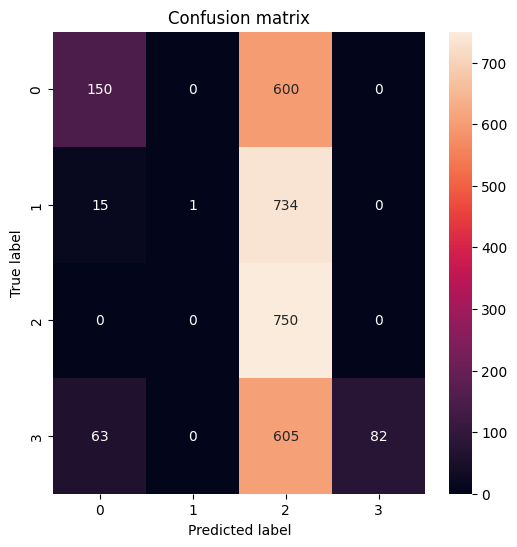

In [ ]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	

## Linear Support Vector Machine

In [ ]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=0, max_iter=5, tol=None).fit(X_train_tfidf, y_train)
y_pred = sgd.predict(X_train_tfidf)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 0.8901932124423332
F1 score: 0.891231315330373


### Testing

In [ ]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = sgd.predict(X_test_tfidf)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy: 0.8801890669954788
F1 score: 0.8801910732054419


### Validation

In [ ]:
y_pred_val = nb.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.32766666666666666
F1 score: 0.2356750682280634


In [ ]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.66      0.20      0.31       750
        hoax       1.00      0.00      0.00       750
  propaganda       0.28      1.00      0.44       750
    reliable       1.00      0.11      0.20       750

    accuracy                           0.33      3000
   macro avg       0.73      0.33      0.24      3000
weighted avg       0.73      0.33      0.24      3000



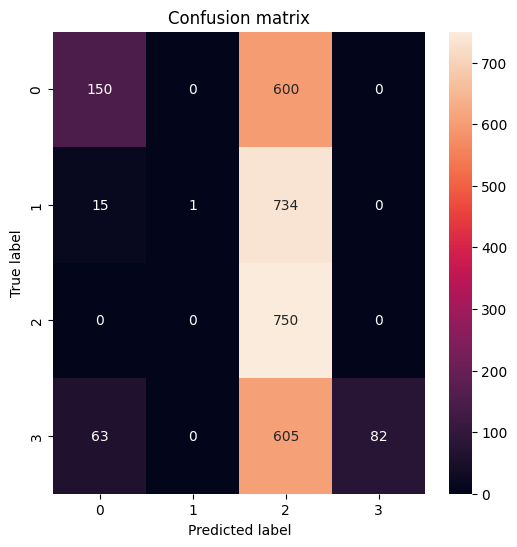

In [ ]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	

## Random Forest

In [ ]:
rfclf = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt').fit(X_train_tfidf, y_train)
y_pred = rfclf.predict(X_train_tfidf)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 1.0
F1 score: 1.0


### Testing

In [ ]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = rfclf.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy: 0.8840937114673243
F1 score: 0.8786598255931944


### Validation

In [ ]:
y_pred_val = rfclf.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.623
F1 score: 0.5826936701495793


## Word2Vec

In [ ]:
train_df['text_clean'] = train_df['text'].apply(lambda x: preprocess(x))
train_df['clean_tokens'] = train_df['text_clean'].apply(lambda x: tokenize(x))
X = train_df['clean_tokens'].values
y = train_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=42)
X_train.shape, X_test.shape

((43786,), (4866,))

In [ ]:
# Train the word2vec model 
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=500,
                                   window=10)
words = set(w2v_model.wv.index_to_key)
print(words)
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])

KeyboardInterrupt: 

In [ ]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(500, dtype=float))

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=200, solver='liblinear').fit(X_train_vect_avg, y_train)
y_pred = clf.predict(X_train_vect_avg)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

### Testing

In [ ]:
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(500, dtype=float))

In [ ]:
y_pred = clf.predict(X_test_vect_avg)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

### Validation

In [ ]:
test_df = pd.read_csv('raw_data/balancedtest.csv', header=None, names=['label', 'text'])
test_df['text_clean'] = test_df['text'].apply(lambda x: preprocess(x))
test_df['clean_tokens'] = test_df['text_clean'].apply(lambda x: tokenize(x))
X_val = test_df['clean_tokens'].values
y_val = test_df['label'].values

In [ ]:
X_val_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_val])
X_val_vect_avg = []
for v in X_val_vect:
    if v.size:
        X_val_vect_avg.append(v.mean(axis=0))
    else:
        X_val_vect_avg.append(np.zeros(500, dtype=float))

In [ ]:
y_pred_val = clf.predict(X_val_vect_avg)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

## gloVe

In [ ]:
embeddings_index = {}
f = open('raw_data/glove.840B.300d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
       coefs = np.asarray(values[1:], dtype='float32')
       embeddings_index[word] = coefs
    except ValueError:
       pass
f.close()

In [ ]:
def sent2vec(words):
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

### Testing

In [ ]:
xtrain_glove = [sent2vec(x) for x in tqdm(train_df['clean_tokens'])]
xtrain_glove = np.array(xtrain_glove)

In [ ]:
y = train_df['label']
clf = LogisticRegression(solver='sag').fit(xtrain_glove, y)
y_pred = clf.predict(xtrain_glove)
print(f"Accuracy: {accuracy_score(y, y_pred)}")
print(f"F1 score: {f1_score(y, y_pred, average='macro')}")

### Validation

In [ ]:
xtest_glove = [sent2vec(x) for x in tqdm(test_df['clean_tokens'])]
xtest_glove = np.array(xtest_glove)
y = test_df['label']
y_pred_val = clf.predict(xtest_glove)
print(f"Accuracy: {accuracy_score(y, y_pred_val)}")
print(f"F1 score: {f1_score(y, y_pred_val, average='macro')}")